In [2]:
import os
import cv2
import time
import numpy as np
import math
import json
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

In [3]:
DATASET_DIR = "/media/jamnicki/HDD/__Datasets/Fire-dataset/fire_danger"
DIR_TRAIN = os.path.join(DATASET_DIR, "train")
DIR_VALID = os.path.join(DATASET_DIR, "validation")
DIR_TEST = os.path.join(DATASET_DIR, "test")

classes = os.listdir(DIR_TRAIN)
assert len(os.listdir(DIR_TRAIN)) == len(os.listdir(DIR_VALID)) == len(os.listdir(DIR_TEST))

In [4]:
### Creating a list of all images : DIR_TRAIN/class_folder/img.jpg
#   A dict for mapping class labels to index

train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    img_dir = os.path.join(DIR_TRAIN, _class)
    for img in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img)
        train_imgs.append(img_path)
    
    img_dir = os.path.join(DIR_VALID, _class)
    for img in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img)
        valid_imgs.append(img_path)
    
    img_dir = os.path.join(DIR_TEST, _class)
    for img in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img)
        test_imgs.append(img_path)

class_to_int = {classes[i] : i for i in range(len(classes))}
class_to_int

{'0': 0, '1': 1, '2': 2, '3': 3}

In [5]:
### Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.path.join(DIR_TRAIN, _class))
    valid_count += len(os.path.join(DIR_VALID, _class))
    test_count += len(os.path.join(DIR_TEST, _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

Total Classes:  4
Total train images:  252
Total valid images:  272
Total test images:  248


In [6]:
### Loading Classification Dataset

def get_transform():
    return T.Compose([
        T.ToTensor(),
        T.Resize(size=(64, 64))
    ])


class FireDangerDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms = None):
        
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
        
    def __getitem__(self, index):
    
        image_path = self.imgs_list[index]
        
        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
    def __len__(self):
        return len(self.imgs_list)

In [9]:
### Loading Classification Dataset

train_dataset = FireDangerDataset(train_imgs, class_to_int, get_transform())
valid_dataset = FireDangerDataset(valid_imgs, class_to_int, get_transform())
test_dataset = FireDangerDataset(test_imgs, class_to_int, get_transform())

#Data Loader  -  using Sampler (YT Video)
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 4,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)

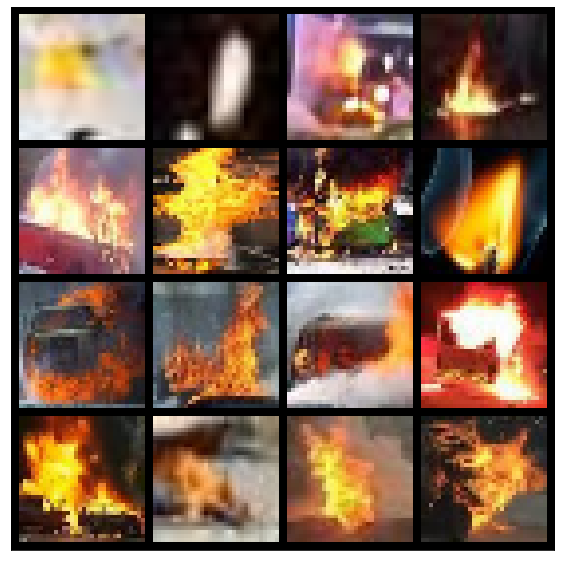

In [7]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [8]:
### Define model
model = models.vgg16(pretrained = True)

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

In [9]:
### Get device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 5

In [10]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [11]:
### Training Code

for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in valid_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

** Epoch 0 ** - Epoch Time 61
Train Loss = 0.7215
Train Accuracy = 88.39285714285714 % 

Val Loss = 0.4503
Val Accuracy = 87.04546 % 

** Epoch 1 ** - Epoch Time 60
Train Loss = 0.2099
Train Accuracy = 92.85714285714286 % 

Val Loss = 0.4576
Val Accuracy = 89.43181999999999 % 

** Epoch 2 ** - Epoch Time 49
Train Loss = 0.1079
Train Accuracy = 96.54762000000001 % 

Val Loss = 0.8545
Val Accuracy = 86.36364 % 

** Epoch 3 ** - Epoch Time 45
Train Loss = 0.0684
Train Accuracy = 97.79762000000001 % 

Val Loss = 0.2953
Val Accuracy = 95.0 % 

** Epoch 4 ** - Epoch Time 44
Train Loss = 0.0404
Train Accuracy = 98.21428571428571 % 

Val Loss = 0.2072
Val Accuracy = 96.25 % 



TOTAL LABEL TEST IMAGES:
	1: 7
	2: 10
	0: 53
{
  "1": {
    "total": 7
  },
  "2": {
    "total": 10,
    "predicted": 10
  },
  "0": {
    "total": 53,
    "predicted": 50
  }
}

1 ACC = 0.0000
2 ACC = 1.0000
0 ACC = 0.9434


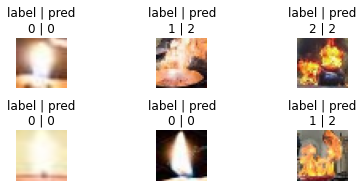

In [23]:
label_data = defaultdict(lambda: defaultdict(int))
for images, labels in test_data_loader:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        preds = model(images)

    for i, pred in enumerate(preds):
        pred_label = str(np.argmax(pred).item())
        real_label = str(labels[i].item())
        label_data[real_label]["total"] += 1
        if real_label == pred_label:
            label_data[real_label]["predicted"] += 1

print(f"TOTAL LABEL TEST IMAGES:")
for label, data in label_data.items():
    print(f"\t{label}: {data['total']}")

print(json.dumps(label_data, indent=2))

print()
for label, data in label_data.items():
    print(f"{label} ACC = {data['predicted'] / data['total']:.4f}")


fig = plt.figure()
N = math.ceil(math.sqrt(len(preds)))
for i, prediction in enumerate(preds):
    img = images[i]
    label = labels[i]
    ax = fig.add_subplot(N, N, i+1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"label | pred\n{label} | {np.argmax(prediction)}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [24]:
acc = np.mean([data['predicted'] / data['total'] for data in label_data.values()])
acc

0.6477987421383647

In [25]:
torch.save(model.state_dict(), f"{epochs}e_fire_danger")